<a href="https://colab.research.google.com/github/SerArtDev/redes-neuronales/blob/main/transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers
Fueron introducidos por Vaswani Aidal en su paper "Attention is all you need". Estos cambiaron radicalmente el campo del procesamiento de lenguaje natural y ahora están siendo aplicado a una amplia variedad de tareas, como procesamiento de imágenes y predicción de series de tiempo. A diferencia de los modelos secuenciales tradicionales, los transformers aprovechan mecanismos de self-attention para procesar datos en paralelo.

Los transformers son la pieza fundamental para modelos de predicción de lenguaje, como GPT y BERT.

La arquitectura de un transformer consta de:

**Encoder > Hidden layer > Decoder**

Tanto el encoder como el decoder cuentan con capas de mecanismos de self-attention (atención interna). En el contexto de procesamiento de lenguaje natural, este mecanismo permite dar más o menos importancia a palabras, dando contexto y relaciones entre estas. En este mecanismo cada palabra está representada por tres vectores: `Query, Key, Value`. La atención es el producto punto entre Query y Key, el cual es usado para determinar el Value.


## Datos secuenciales
Los datos secuenciales son aquellos que dependen de los datos anteriores, como datos en series de tiempo, audios y textos. Los mecanismos de self-attention permiten tener en cuenta todos los datos al mismo tiempo, no solo el que se está procesando.

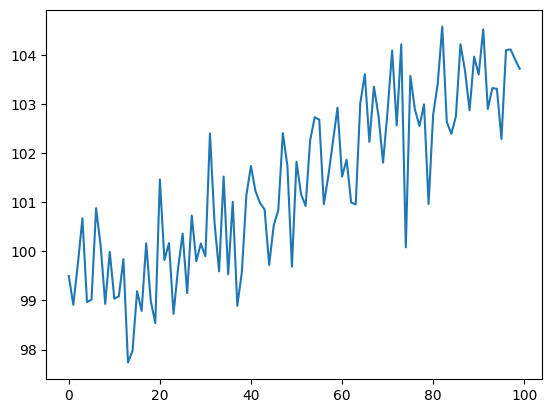

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout

# Cremos datos de precios de mercado
np.random.seed(42)
data_length = 2000
trend = np.linspace(100, 200, data_length)
noise = np.random.normal(-1, 1, data_length)
synthetic_data = trend + noise
plt.plot(synthetic_data[0:100])
# Almacenamos los datos
data = pd.DataFrame(synthetic_data, columns=['Close'])
data.to_csv('stock_prices.csv', index=False)

In [ ]:
data = pd.read_csv('stock_prices.csv')
data = data[['Close']].values
# Normalización de datos
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
# Preparación de datos para entrenamiento
def create_dataset(data, tinme_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps - 1):
        a = data[i:(i + time_steps), 0]
        X.append(a)
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 100
X, Y = create_dataset(data, time_steps)
X = X.reshape(X.shape[0], X.shape[1], 1)

print(X.shape)
print(Y.shape)

(1899, 100, 1)
(1899,)


## Mecanismo de atención
 Multi-head self-attention. Este permite enfocarse en varias partes de la entrada al mismo tiempo.

In [ ]:
# Creamos una capa implementando el mecanismo multi-head self-attention.
class MultiHeadSelfAttention(Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.projection_dim = embed_dim // num_heads
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)

    # La atención calcula el puntaje de atención y la suma poderada de los
    # valores
    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    # Divide la entrada en múltiples cabezas para calcular la atención en
    # paralelo
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    # Aplica el mecamismo de self-attention (split_heads) y combina las cabezas
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        attention, _ = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.dense(concat_attention)
        return output

In [ ]:
# Definimos el bloque del transformer
class TransformerBlock(Layer):

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [
                Dense(ff_dim, activation="relu"),
                Dense(embed_dim),
            ]
        )
        # Capas de normalización
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        # capas dropout para prevenir el overfitting
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    # El método call aplica self-attention seguido por el feedforward con
    # conexiones residuales y capa de normalización.
    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
# Aplicación de la capa encoder

class EncoderLayer(Layer):
    # Esta clase es similar a TransformerBlock, pero es reusable en la
    # arquitectura Transformer
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1):
        super(EncoderLayer, self).__init__()
        # Está formada por una capa MultiHeadSelfAttention seguido por una red
        # neuronal feedforward.
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [
                Dense(ff_dim, activation="relu"),
                Dense(embed_dim),
            ]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    # El método call aplica la self-attention y luego la red feedforward con
    # conexiones residuales y capa de normalización.
    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
# Implementación de Transformer Encoder
class MultiHeadSelfAttention(Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.projection_dim = embed_dim // num_heads
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights


    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])


    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        attention, _ = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)


    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# El transformer encoder usa TransformerBlock
class TransformerEncoder(Layer):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.num_layers = num_layers
        self.embed_dim = embed_dim
        self.enc_layers = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
        self.dropout = Dropout(rate)

    def call(self, inputs, training=False):
        x = inputs
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training)
        return x

In [ ]:
# Ejemplo de uso
embed_dim = 128
num_heads = 8
ff_dim = 512
num_layers = 4

transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim)
inputs = tf.random.uniform((1, 100, embed_dim))
outputs = transformer_encoder(inputs, training=False)
print(outputs.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'transformer_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


(1, 100, 128)


In [ ]:
embed_dim = 128
num_heads = 8
ff_dim = 512
num_layers = 4

# Definir el transformer encoder
transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim)

# Hacemos el modelo
input_shape = (X.shape[1], X.shape[2])
inputs = tf.keras.Input(shape=input_shape)


x = tf.keras.layers.Dense(embed_dim)(inputs)
encoder_outputs = transformer_encoder(x)
flatten = tf.keras.layers.Flatten()(encoder_outputs)
outputs = tf.keras.layers.Dense(1)(flatten)
model = tf.keras.Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'transformer_encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 100, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 100, 128)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_1                │ (None, 100, 128)            │         793,088 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 1)                   │          12,801 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 806,145 (3.08 MB)

 Trainable params: 806,145 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entrenamiento
model.fit(X, Y, epochs=20, batch_size=32)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 65s 817ms/step - loss: 13.6811
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 830ms/step - loss: 0.2497
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 48s 808ms/step - loss: 0.2026
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 803ms/step - loss: 0.1308
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 804ms/step - loss: 0.1843
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 819ms/step - loss: 0.1300
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 812ms/step - loss: 0.2075
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 84s 848ms/step - loss: 0.0897
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 79s 794ms/step - loss: 0.0960
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 769ms/step - loss: 0.0995
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 777ms/step - loss: 0.0938
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 89s 897ms/step - loss: 0.0826
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 51s 850ms/step - loss: 0.0779
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 84s 883ms/step - loss: 0.1377
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 77s

60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 254ms/step


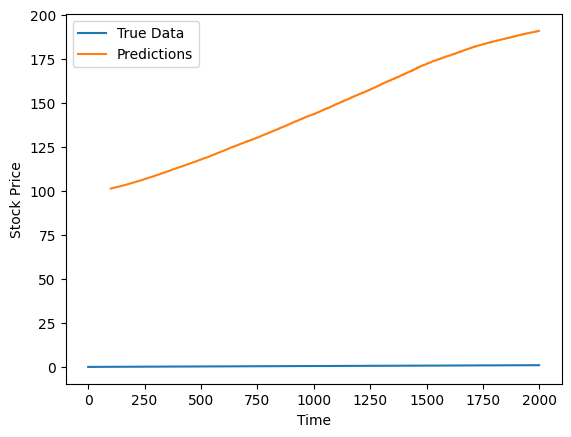

In [ ]:
# Evualuar y hacer predicciones
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)


plt.plot(data, label='True Data')
plt.plot(np.arange(time_steps, time_steps + len(predictions)), predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Transformers en Vision, Speech recognition y aprendizaje reforzado
La arquitectura de los transformers los hace muy versátiles, permitiendo usarlos en otros campos, como el de la visión y reconocimiento de imágenes. A estos se les llaman Vision Transformers (ViTs) y funcionan dividiendo la imagen en distintos parches y los trata como una secuencia, similar a como ocurre con las palabras.

Los transformers también son aplicados en reconocimiento de voz, convirtiendo primero el audio en un espectrograma y prediciendo las palabras usadas en el contexto.

También se usan en aprendizaje reforzado (RL) ya que puede reconocer secuencias de estados y acciones. Los decision transformers son usados para este fin, prediciendo futuras acciones basado en las pasadas.

## Transformers en Generación de texto

In [ ]:
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import get_file

# Cargar conjunto de datos
path_to_file = get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

# Previsualización
print(text[:1000])


First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [ ]:
# Preprocesamiento
vocab_size = 10000
seq_length = 100
# Vectorización
vectorizer = TextVectorization(max_tokens=vocab_size, output_mode='int')
text_ds = tf.data.Dataset.from_tensor_slices([text]).batch(1)
vectorizer.adapt(text_ds)
vectorized_text = vectorizer([text])[0]
print("Vectorized text shape:", vectorized_text.shape)
print("First 10 vectorized tokens:", vectorized_text.numpy()[:10])

Vectorized text shape: (202646,)
First 10 vectorized tokens: [ 89 270 138  36 982 144 673 125  16 106]


In [ ]:
# Generador de secuencias
def create_sequences(text, seq_length):
    input_seqs = []
    target_seqs = []
    for i in range(len(text) - seq_length):
        input_seq = text[i:i + seq_length]
        target_seq = text[i + 1:i + seq_length + 1]
        input_seqs.append(input_seq)
        target_seqs.append(target_seq)
    return np.array(input_seqs), np.array(target_seqs)

# Generar secuencias
X, Y = create_sequences(vectorized_text.numpy(), seq_length)
# Verificar si se generan las secuencias
print("Número de secuencias generadas:", len(X))
print("Muestra de secuencia de entrada:", X[0] if len(X) > 0 else "Secuancia vacía")
# Verificación
assert X.size > 0, "X vacío"
assert Y.size > 0, "Y vacío"
X = tf.convert_to_tensor(X)
Y = tf.convert_to_tensor(Y)
print("Tamaño de X:", X.shape)
print("Tamaño de Y:", Y.shape)

Número de secuencias generadas: 202546
Muestra de secuencia de entrada: [  89  270  138   36  982  144  673  125   16  106   34  106  106   89
  270    7   41   34 1286  344    4  200   64    4 3690   34 1286 1286
   89  270   89    7   93 1187  225   12 2442  592    4    2  307   34
   36 2655   36 2655   89  270   72   79  506   27    3   56   24 1390
   57   40  161 2328  644    9 4980   34   32   54 2863  885   72   17
   18  163  146  146  165  270   74  218   46  595   89  270   36   41
 6739  172  595    2 1780   46   29 1323 5151   47   58 4151   79   39
   60   58]
Tamaño de X: (202546, 100)
Tamaño de Y: (202546, 100)


In [ ]:
# Definición del transformador
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Model

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TransformerModel(Model):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length):
        super(TransformerModel, self).__init__()
        self.embedding = Embedding(vocab_size, embed_dim)
        self.pos_encoding = self.positional_encoding(seq_length, embed_dim)
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)]
        self.dense = Dense(vocab_size)

    def positional_encoding(self, seq_length, embed_dim):
        angle_rads = self.get_angles(np.arange(seq_length)[:, np.newaxis], np.arange(embed_dim)[np.newaxis, :], embed_dim)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, embed_dim):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
        return pos * angle_rates

    def call(self, inputs, training=False):
        seq_len = tf.shape(inputs)[1]
        x = self.embedding(inputs)
        x += self.pos_encoding[:, :seq_len, :]
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)
        output = self.dense(x)
        return output

In [ ]:
# Hyperparameters
embed_dim = 256
num_heads = 4
ff_dim = 512
num_layers = 4

# Build the Transformer model
model = TransformerModel(vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length)

# Provide input shape to build the model by passing a dummy input with maxval specified
_ = model(tf.random.uniform((1, seq_length), maxval=vocab_size, dtype=tf.int32))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Summary of the model
model.summary()

Model: "transformer_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (1, 100, 256)               │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_8                  │ ?                           │       1,315,840 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_9                  │ ?                           │       1,315,840 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_10                 │ ?                           │       1,315,840 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_11                 │ ?                           │       1,315,840 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (1, 100, 10000)             │       2,570,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,393,360 (39.65 MB)

 Trainable params: 10,393,360 (39.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entrenamiento
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback to stop training if the loss doesn't improve
early_stopping = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

# Train the transformer model on the full input and target sequences
history = model.fit(X, Y, epochs=20, batch_size=32, callbacks=[early_stopping])

# Plot training loss to monitor model performance over epochs
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


Epoch 1/20
1093/6330 ━━━━━━━━━━━━━━━━━━━━ 9:33:38 7s/step - loss: 11.7844

In [ ]:
# Generación de texto mediante una función
def generate_text(model, start_string, num_generate=100, temperature=1.0):
    # Convert the start string to a vectorized format
    input_eval = vectorizer([start_string]).numpy()

    # Ensure the input length is the same as the model's expected input shape
    if input_eval.shape[1] < seq_length:
        # Pad the input if it's shorter than the expected sequence length
        padding = np.zeros((1, seq_length - input_eval.shape[1]))
        input_eval = np.concatenate((padding, input_eval), axis=1)
    elif input_eval.shape[1] > seq_length:
        # Truncate the input if it's longer than the expected sequence length
        input_eval = input_eval[:, -seq_length:]

    input_eval = tf.convert_to_tensor(input_eval)

    # Initialize an empty list to store generated text
    text_generated = []

    # Start generating text
    for i in range(num_generate):
        # Make predictions using the model
        predictions = model(input_eval)

        # Remove only the batch dimension, keep the logits as 2D (batch_size, vocab_size)
        predictions = predictions[0]  # This should be of shape [vocab_size]

        # Apply temperature to predictions
        predictions = predictions / temperature

        # Ensure predictions has two dimensions
        predictions = tf.expand_dims(predictions, 0)  # Adding a batch dimension to make it [1, vocab_size]

        # Use a categorical distribution to predict the next word
        predicted_id = tf.random.categorical(predictions, num_samples=1)[0, 0].numpy()

        # Update the input tensor to include the predicted word, maintaining the sequence length
        input_eval = np.append(input_eval.numpy(), [[predicted_id]], axis=1)  # Append predicted token
        input_eval = input_eval[:, -seq_length:]  # Keep only the last `seq_length` tokens
        input_eval = tf.convert_to_tensor(input_eval)  # Convert back to tensor

        # Append the predicted word to the generated text
        text_generated.append(vectorizer.get_vocabulary()[predicted_id])

    # Return the generated text starting from the initial seed
    return start_string + ' ' + ' '.join(text_generated)

# Generate text with temperature control
start_string = "To be, or not to be"
generated_text = generate_text(model, start_string, temperature=0.7)  # Lower temperature for more focused predictions
print(generated_text)